In [1]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import torch.nn.functional as Acivation
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/tdata.zip', 'r')
file = zip_ref.extractall("./tmp")
zip_ref.close()

print("o")

o


In [4]:
DATASET2="/content/tmp/tdata/valid"

In [5]:
CATEGORIES=["Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___healthy","Tomato___Late_blight","Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot","Tomato___Tomato_mosaic_virus","Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
        

In [6]:
test_data=[]

for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET2,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))
            test_data.append([img,label])
            


print(len(test_data))

4585


In [7]:
random.shuffle(test_data)
random.shuffle(test_data)
random.shuffle(test_data)
random.shuffle(test_data)
# test_data

In [8]:
# ss

In [9]:
X_test=[]
y_test=[]

In [10]:
for features,label in test_data:
    X_test.append(features)
    y_test.append(label)
    

In [11]:
Z=[]
for i in y_test:
    if i==0:
        Z.append("BACTERIAL SPOT")
    elif i==1:
        Z.append("EARLY BLIGHT")
    elif i==2:
        Z.append("HEALTHY")
    elif i==3:
        Z.append("LATE BLIGHT")
    elif i==4:
        Z.append("LEAF MOLD")
    elif i==5:
        Z.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Z.append("SPIDER MITE")
    elif i==7:
        Z.append("TARGET SPOT")
    elif i==8:
        Z.append("MOSAIC VIRUS")
    else:
        Z.append("YELLOW LEAF CURL VIRUS")

In [12]:
len(X_test),len(y_test)

(4585, 4585)

In [13]:
X_test=np.array(X_test).reshape(-1, 224,224,3)
X_test.shape

(4585, 224, 224, 3)

In [14]:
class TOMATO_DATASET(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x_batch = self.x[index]
        y_batch = self.y[index]

        if self.transform is not None:
            x_batch = self.transform(x_batch)
        
        y_batch = torch.from_numpy(np.array(y_batch))

        return x_batch, y_batch


In [15]:

transform1 = transforms.Compose([
    #transforms.Resize(224, 224),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, ), (0.5, ) )
])


valid_dataset = TOMATO_DATASET(X_test, y_test, transform=transform1)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)



dataiter = iter(valid_loader)
images, label = dataiter.next()

print(images.shape, label.shape)

torch.Size([100, 3, 224, 224]) torch.Size([100])


In [16]:
class CNN(nn.Module):

    def __init__(self,vgg_features):
        super().__init__()

        self.features = vgg_features

    def forward(self, z):
        z = self.features(z)
        z = z.view(-1, 512*7*7)

        return z


class CNN_LSTM(nn.Module):

    def __init__(self, vgg_features):
        super(CNN_LSTM, self).__init__()
        self.cnn = CNN(vgg_features)
        self.rnn = nn.LSTM(
            input_size=512*7*7, 
            hidden_size=64, 
            num_layers=1,
            batch_first=True)
        self.linear = nn.Linear(64,10)

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)
        c_out = self.cnn(c_in)
        r_in = c_out.view(batch_size, timesteps, -1)
        r_out, (h_n, h_c) = self.rnn(r_in)
        r_out2 = self.linear(r_out[:, -1, :])
        
        return F.log_softmax(r_out2, dim=1)

In [17]:
vgg_f =  models.vgg16(pretrained=True).features
model = CNN_LSTM(vgg_f)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [18]:
# load model
PATH = '/content/drive/MyDrive/Colab Notebooks/CSE16/Luna/weights/lstm(e20).pth'
model = torch.load(PATH)
# print(model)

In [19]:
from PIL import Image

# compose allow us to chain multiple transform together
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))

])

CATEGORIES=["Tomato___Bacterial_spot","Tomato___Early_blight",
            "Tomato___healthy","Tomato___Late_blight",
            "Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot",
            "Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot",
            "Tomato___Tomato_mosaic_virus","Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
        
path = '/content/tmp/tdata/valid/Tomato___Target_Spot/01f0e0cb-83a7-4190-9645-bd06b70c8d65___Com.G_TgS_FL 8318_new30degFlipLR.JPG'
img = Image.open(path)
# img.shape
img = transform1(img)
img.shape

image = img.view(1,1,img.shape[0], img.shape[1], img.shape[2])
image.shape


output = model(image.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())
print(CATEGORIES[pred[0].item()])

7
Tomato___Target_Spot


In [20]:
dataiter = iter(valid_loader)
images, label = dataiter.next()

print(images.shape, label.shape)

torch.Size([100, 3, 224, 224]) torch.Size([100])


In [21]:
images = images.view(images.shape[0], 1,images.shape[1], images.shape[2], images.shape[3])
images.shape

torch.Size([100, 1, 3, 224, 224])

In [27]:
output = model(images.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())

0


In [28]:
pred

tensor([0, 3, 9, 6, 7, 1, 8, 5, 3, 1, 9, 1, 2, 3, 1, 5, 9, 8, 7, 0, 1, 8, 9, 7,
        9, 9, 5, 8, 8, 8, 8, 5, 4, 4, 7, 2, 9, 7, 0, 5, 2, 9, 5, 9, 8, 0, 7, 7,
        1, 4, 1, 0, 3, 5, 2, 4, 5, 2, 8, 3, 9, 3, 9, 0, 3, 1, 7, 4, 2, 0, 4, 0,
        4, 1, 7, 2, 4, 9, 7, 4, 2, 4, 9, 1, 7, 9, 9, 0, 2, 3, 2, 8, 7, 8, 5, 0,
        5, 0, 0, 0], device='cuda:0')

In [29]:
label

tensor([0, 3, 9, 6, 7, 1, 8, 5, 3, 1, 9, 1, 2, 3, 1, 5, 9, 8, 7, 0, 1, 8, 9, 7,
        9, 9, 5, 8, 8, 8, 8, 5, 4, 4, 7, 2, 9, 7, 0, 5, 2, 9, 5, 9, 8, 0, 7, 7,
        1, 4, 1, 0, 3, 5, 2, 4, 5, 2, 8, 3, 9, 3, 9, 0, 3, 1, 7, 4, 2, 0, 4, 0,
        4, 1, 7, 2, 4, 9, 7, 4, 2, 4, 9, 1, 7, 9, 9, 0, 2, 3, 2, 8, 7, 8, 5, 0,
        5, 0, 0, 0])

In [30]:
y_test = label.tolist()
y_pred = pred.tolist()

In [35]:
y_pred = [0, 3, 9, 6, 7, 1, 8, 5, 3, 1, 9, 1, 2, 3, 1, 5, 9, 8, 7, 0, 1, 8, 9, 7,
        9, 9, 5, 8, 8, 8, 8, 5, 3, 4, 7, 2, 9, 7, 0, 5, 2, 9, 5, 9, 8, 0, 5, 7,
        1, 4, 1, 0, 3, 5, 2, 4, 5, 2, 8, 3, 9, 3, 9, 0, 3, 1, 7, 4, 2, 0, 4, 0,
        4, 1, 7, 2, 4, 9, 7, 4, 2, 4, 9, 1, 7, 9, 9, 0, 2, 3, 2, 8, 7, 8, 5, 0,
        5, 0, 0, 0]

In [36]:
y_test = [0, 3, 9, 6, 7, 1, 8, 5, 3, 1, 9, 1, 2, 3, 1, 5, 9, 8, 7, 0, 1, 8, 9, 7,
        9, 9, 5, 8, 8, 8, 8, 5, 4, 4, 7, 2, 9, 7, 0, 5, 2, 9, 5, 9, 8, 0, 7, 7,
        1, 4, 1, 0, 3, 5, 2, 4, 5, 2, 8, 3, 9, 3, 9, 0, 3, 1, 7, 4, 2, 0, 4, 0,
        4, 1, 7, 2, 4, 9, 7, 4, 2, 4, 9, 1, 7, 9, 9, 0, 2, 3, 2, 8, 7, 8, 5, 0,
        5, 0, 0, 0]

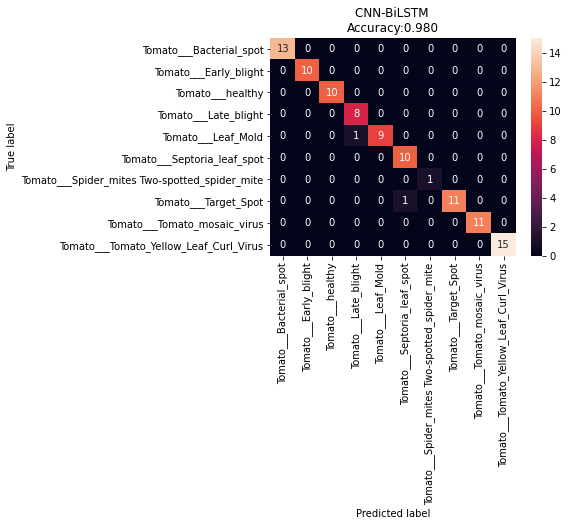

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import pandas as pd


# Creates a confusion matrix
cm = confusion_matrix(y_test, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = CATEGORIES, 
                     columns = CATEGORIES)

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('CNN-BiLSTM \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('foo.png')
plt.show()